# Plot scan

In [25]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
from auxPlots import interpolateData,getContours,saveContours
from nloGluinoXsec import xsecF
pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [26]:
#Load scan data
dataDF = pd.read_pickle('./strongRecast.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

### Get k-factors

In [27]:
dataDF['kfactor'] = dataDF['mLSP'].apply(xsecF)/dataDF['Total xsec (pb)']
dataDF['robs'] = dataDF['robs']*dataDF['kfactor']
dataDF['robs_comb'] = dataDF['robs_comb']*dataDF['kfactor']

### Define colors and plotting order

In [28]:
colors = sns.color_palette("Paired",10)
colorsPink = sns.color_palette("colorblind",8)
colorDict = {'HighPT' : colorsPink[4], #light pink
             'Trackless' : colors[4] }
srs = {'HighPT' : dataDF[(dataDF['SR'] == 'HighPT')], 'Trackless' : dataDF[(dataDF['SR'] == 'Trackless')]}

atlasCurve = np.genfromtxt('../../ATLAS_data/HEPData-ins2628398-v1-csv/excl_strong_mgluino_2400_GeV_obs_nominal.csv',delimiter=',',comments='#')
# atlasCurve = np.genfromtxt('../ATLAS_data/HEPData-ins2628398-v1-csv/excl_strong_mgluino_2000_GeV_obs_nominal.csv',delimiter=',',comments='#')

### Plot excluded points grouped by most excluding analysis

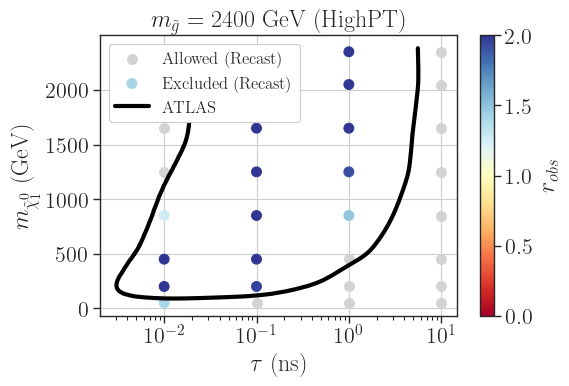

In [29]:

plt.figure(figsize=(6,4))
for sr,data in srs.items():
    if sr != 'HighPT': continue
    excluded = data[data['robs'] > 1.0]
    allowed = data[data['robs'] < 1.0]
    x = allowed['tau_ns']
    y = allowed['mLLP']
    plt.scatter(x,y,color='lightgray',s=50,label='Allowed (Recast)')
    x = excluded['tau_ns']
    y = excluded['mLLP']
    z = excluded['robs']
    color = colorDict[sr]
    # plt.scatter(x,y,color=color,label=sr,s=50)
    plt.scatter(x,y,c=z,label='Excluded (Recast)',s=50,cmap=cm,vmin=0,vmax=2)

plt.plot(atlasCurve[:,0],atlasCurve[:,1],linewidth=3,c='black',linestyle='solid',label='ATLAS')
plt.colorbar(label=r'$r_{obs}$')
lgd = plt.legend(loc='upper left',framealpha=1.,fontsize=12)
plt.xscale('log')
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$m_{\tilde \chi_1^0}$ (GeV)')
# plt.xlim(1e-3,30)
# plt.ylim(0,500)
plt.grid()
plt.tight_layout()
plt.title(r'$m_{\tilde g} = 2400$ GeV (HighPT)')
plt.savefig('strong_Fig12.png')
plt.show()

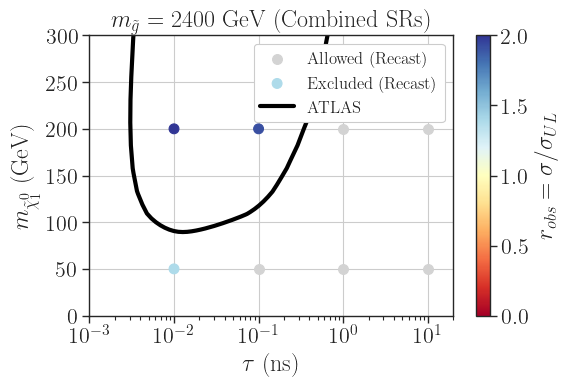

In [30]:

plt.figure(figsize=(6,4))
for sr,data in srs.items():
    if sr != 'HighPT': continue
    excluded = data[data['robs_comb'] > 1.0]
    allowed = data[data['robs_comb'] < 1.0]
    x = allowed['tau_ns']
    y = allowed['mLLP']
    plt.scatter(x,y,color='lightgray',s=50,label='Allowed (Recast)')
    x = excluded['tau_ns']
    y = excluded['mLLP']
    z = excluded['robs_comb']
    color = colorDict[sr]
    # plt.scatter(x,y,color=color,label=sr,s=50)
    plt.scatter(x,y,c=z,label='Excluded (Recast)',s=50,cmap=cm,vmin=0,vmax=2)


plt.plot(atlasCurve[:,0],atlasCurve[:,1],linewidth=3,c='black',linestyle='solid',label='ATLAS')
plt.colorbar(label=r'$r_{obs} = \sigma/\sigma_{UL}$')
lgd = plt.legend(loc='upper right',framealpha=1.,fontsize=12)
plt.xscale('log')
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'$m_{\tilde \chi_1^0}$ (GeV)')
plt.xlim(1e-3,20)
plt.ylim(0,300)
plt.grid()
plt.tight_layout()
plt.title(r'$m_{\tilde g} = 2400$ GeV (Combined SRs)')
plt.savefig('strong_Fig12_combinedSRs.png')
plt.show()